## Quora Insincere Question Classification

### Abstract 

The objective is to predict whether a question asked on Quora is sincere or not.
An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
- Has an exaggerated tone to underscore a point about a group of people
- Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory
- Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
- Makes disparaging attacks/insults against a specific person or group of people

### Baseline - Logistic Regression with tf-idf

I will try various Deep Learning Algorithms to see which works best of this dataset like LSTM, SimpleRNN, Conv1D, GRU etc. I will also use pre-trained word embeddings in few algorithms. As a baseline, I will use Naive Bayes and Logistic regression for this. 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time, gc, warnings

import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, GRU, SimpleRNN
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from wordcloud import WordCloud, STOPWORDS

np.random.seed(42)
warnings.filterwarnings("ignore")
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation

%matplotlib inline

In [2]:
os.chdir(r'N:\ADVANCE DATA SCIENCE\ASSIGNMENTS\Assignment 3')

In [3]:
df_Quora = pd.read_csv('quora_questions_.csv')

In [4]:
df_Quora[df_Quora.target == 0].head(5)

,qid,question_text,target
0,69d762db89f677e2b38d,How can I live fully happier life?,0
1,de052885a7cb6483c482,What is the difference between IT and computer...,0
2,5cf30b565aa71a3ce65c,Why a suit is the dress code of business people?,0
3,a2483d6b6debff584f87,How can you get the earnest money loan for a b...,0
4,c93fef8401e553bbee16,Why would an atheist care if others celebrate ...,0


In [5]:
df_Quora[df_Quora.target == 1].head(5)

,qid,question_text,target
61266,9d91dabfc5358b6e9b4a,"Has Trump (since becoming president), ever com...",1
61267,cafdbedf2152a331cf88,Why Turkish people and Iranians look white des...,1
61268,877e654f6097f6dde056,"Do Hungarians envy Romania, because they are b...",1
61269,341b769d29966cae4b16,"I just got a message that my answer had been ""...",1
61270,136b7b3b0dc24a6256c0,What does black man cum taste like?,1


### Data Pre-processing

In [6]:
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [7]:
def clean_text(question):
    """
    This function receives comments and returns clean word-list
    """
    question = question.lower()
    question = re.sub("\\n", "", question)
    question = re.sub("\'", "", question)
    question = re.sub("\W+", " ", question)
    
    #Split the sentences into words
    words = tokenizer.tokenize(question)
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in punctuations]
    #words = [''.join(x for x in w if x.isalpha()) for w in words]

    clean_sen = " ".join(words)
    
    return clean_sen

In [8]:
df_Quora["question_text_"] = df_Quora["question_text"].apply(lambda question: clean_text(question))
df_Quora.head()

,qid,question_text,target,question_text_
0,69d762db89f677e2b38d,How can I live fully happier life?,0,how can i live fully happier life
1,de052885a7cb6483c482,What is the difference between IT and computer...,0,what be the difference between it and computer...
2,5cf30b565aa71a3ce65c,Why a suit is the dress code of business people?,0,why a suit be the dress code of business people
3,a2483d6b6debff584f87,How can you get the earnest money loan for a b...,0,how can you get the earnest money loan for a b...
4,c93fef8401e553bbee16,Why would an atheist care if others celebrate ...,0,why would an atheist care if others celebrate ...


In [9]:
features = df_Quora['question_text_']
target = df_Quora['target']

### Stratified Split 

To avoid Sampling Bias due to Random Sampling, I will split the data using Stratifed Split as the 2 output classes are imbalanced. 

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.1, stratify=target, random_state=100)

### Baseline - Tf-idf & Logistic Regression

In [11]:
# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(X_train.values.tolist() + X_test.values.tolist())
train_tfidf = tfidf_vec.transform(X_train.values.tolist())
test_tfidf = tfidf_vec.transform(X_test.values.tolist())

Y_train = Y_train.values

In [12]:
Y_test = Y_test.values

In [13]:
model = linear_model.LogisticRegression(C=5, solver='sag')
model.fit(train_tfidf, Y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
Y_pred_ = model.predict(test_tfidf)
Y_pred_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
metrics.f1_score(Y_test, Y_pred_)

0.7900414937759336

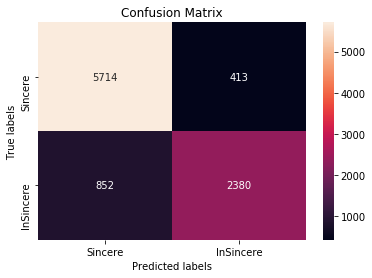

In [16]:
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, Y_pred_), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

Getting the best threshold based on test set 

In [17]:
Y_pred = model.predict_proba(test_tfidf)[:,1]
Y_pred

array([0.11481361, 0.3053329 , 0.05454121, ..., 0.08432779, 0.01435933,
       0.01512414])

In [18]:
for thresh in np.arange(0.1, 0.60, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))

F1 score at threshold 0.1 is 0.7131101341449667
F1 score at threshold 0.12 is 0.7438995498696991
F1 score at threshold 0.14 is 0.7654503010197813
F1 score at threshold 0.16 is 0.7802350562365727
F1 score at threshold 0.18 is 0.7932291666666665
F1 score at threshold 0.2 is 0.8024986709197235
F1 score at threshold 0.22 is 0.8108621860149355
F1 score at threshold 0.24 is 0.8174757281553398
F1 score at threshold 0.26 is 0.8219332956472584
F1 score at threshold 0.28 is 0.8253877082136704
F1 score at threshold 0.3 is 0.8241132681360386
F1 score at threshold 0.32 is 0.8222024339566637
F1 score at threshold 0.34 is 0.8233173076923077
F1 score at threshold 0.36 is 0.819926873857404
F1 score at threshold 0.38 is 0.8157528957528957
F1 score at threshold 0.4 is 0.8109631949882538
F1 score at threshold 0.42 is 0.8084230525649145
F1 score at threshold 0.44 is 0.8054356514788168
F1 score at threshold 0.46 is 0.8011639185257032
F1 score at threshold 0.48 is 0.7967905682004257
F1 score at threshold 0.5

So we are getting a better F1 score of 0.824 for this model at 0.3!